In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf
import tensorflow as tf

In [9]:
# Usando o Yahoo Finance para baixar os dados históricos do Bitcoin (BTC-USD)
dados = yf.download('BTC-USD', start='2014-01-01', end='2024-11-11')

# Pré-processamento de dados
dados = dados[['Close']]

[*********************100%***********************]  1 of 1 completed


In [10]:
# Padronização dos dados para melhorar a performance do modelo
padronizador = StandardScaler()
dados = padronizador.fit_transform(dados)

In [11]:
dados

array([[-0.88842045],
       [-0.89003742],
       [-0.89149463],
       ...,
       [ 2.85184467],
       [ 2.86331746],
       [ 3.04496833]])

In [12]:
# Padronização (média 0, desvio padrão 1)
scaler = StandardScaler()
dados_scaled = scaler.fit_transform(dados)

# Função para criar os dados de entrada e saída
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Definir o número de passos de tempo
time_step = 300

# Criar os dados de treino e teste
X, y = create_dataset(dados_scaled, time_step)

# Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Teste com o modelo SVR e ajuste de parâmetros
model = SVR(kernel='rbf', C=1, epsilon=0.55)
model.fit(X_train, y_train)

# Previsões com o modelo
y_pred = model.predict(X_test)

# Métricas de avaliação
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Modelo SVR com C=1 e epsilon=0.5: MSE={mse:.4f}, R²={r2:.4f}")

# Inverter a padronização dos dados
predicted_price = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))



Modelo SVR com C=1 e epsilon=0.5: MSE=0.5096, R²=0.3212


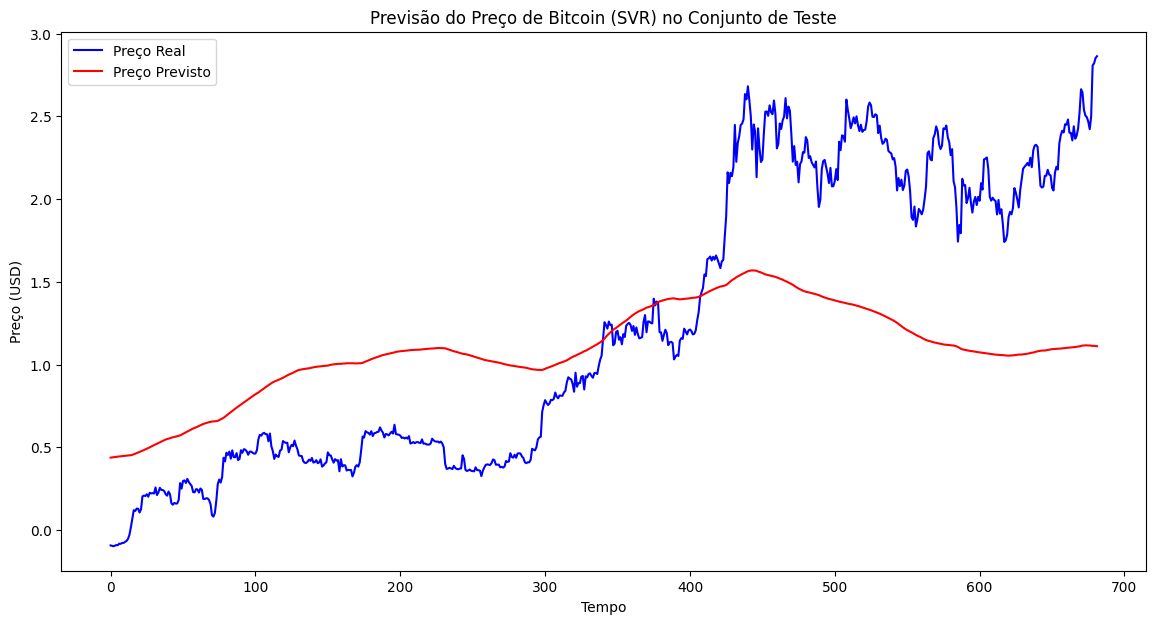

In [13]:
# Visualizar os resultados do conjunto de teste
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='blue', label='Preço Real')
plt.plot(predicted_price, color='red', label='Preço Previsto')
plt.title('Previsão do Preço de Bitcoin (SVR) no Conjunto de Teste')
plt.xlabel('Tempo')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

In [14]:
# Criar o modelo LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dense(units=1)  # Camada de saída com um único valor (preço do Bitcoin)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Prever e reverter a normalização
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Reverter a normalização dos dados reais
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 255ms/step - loss: 0.1879 - val_loss: 0.0202
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - loss: 0.0092 - val_loss: 0.0319
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 263ms/step - loss: 0.0079 - val_loss: 0.0175
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - loss: 0.0061 - val_loss: 0.0107
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 266ms/step - loss: 0.0057 - val_loss: 0.0149
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 266ms/step - loss: 0.0050 - val_loss: 0.0129
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - loss: 0.0045 - val_loss: 0.0127
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - loss: 0.0040 - val_loss: 0.0069
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 259ms/step - loss: 0.0043 - val_loss: 0.0108
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 251ms/step - loss: 0.0038 - val_loss: 0.0059
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


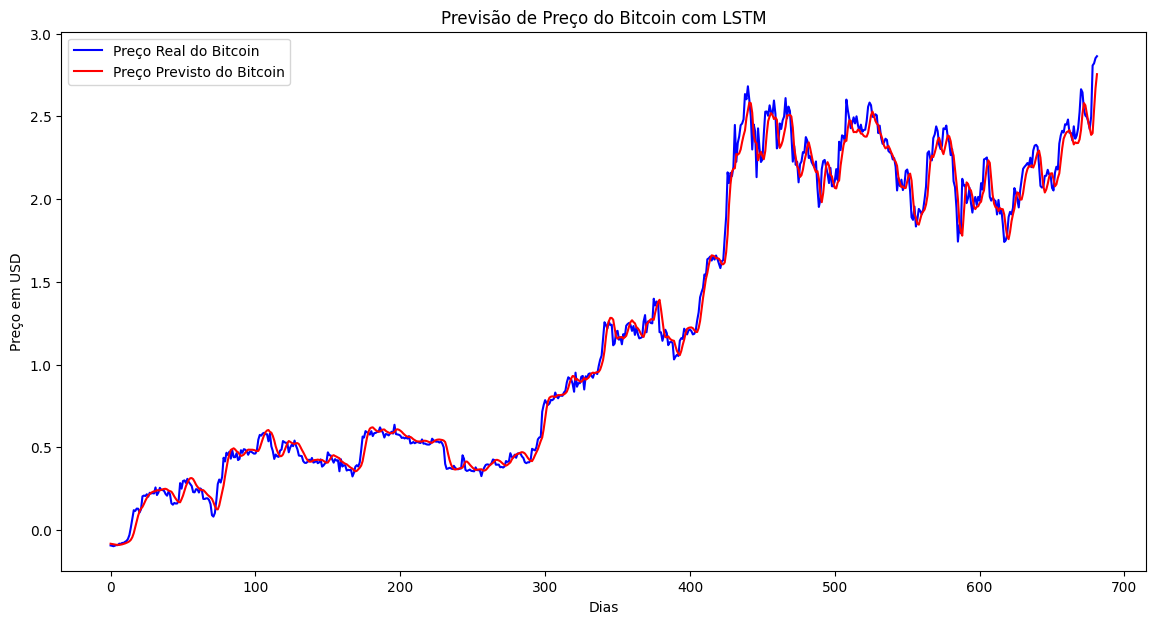

In [15]:

# Visualizar os resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Preço Real do Bitcoin')
plt.plot(predictions, color='red', label='Preço Previsto do Bitcoin')
plt.title('Previsão de Preço do Bitcoin com LSTM')
plt.xlabel('Dias')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()